# Demonstration of the experiment for reproducibility
## Gabor scattering vs. Gabor transform comparison on Good Sounds dataset

Article: "Gabor frames and deep scattering networks in audio processing" <br> Authors: R. Bammer, M. Dörfler, P. Harar<br> Submitted to a special issue (Harmonic Analysis and Applications) of Axioms (ISSN 2075-1680)


# Summary

In this notebook, we prepared the Good Sounds data. All audio files were stripped of the silence using Sox, split into Tukey windowed segments of equal duration according to config parameters. These files were saved to disk and metadata about them were saved to csv_preprocessed.

Next, these segments were splitted into stratified train, validation and test sets with specified number of samples from each class in test and valid sets and the rest of non_leaking segments in train set. Metadata are saved in csv_split.

Segments were transformed into desired time-frequency representation according to csv_split which was shuffled and splitted to batches of equal size with the last batch containing all remaining samples. Batches were saved to disk as .npz files for fast loading. Metadata were saved to batches.csv in appropriate folders.

TimeFrequencySequence object will load and return appropriate batch based on its index. If the batch was removed from disk before initialization of the object, it will be created again.

Then the Convolutional Neural Network model was created in Keras. In this experiment, we did not do any exhaustive hyperparameter optimization, but we used the knowledge from our previous experiments published in another paper.

# Outline

1. Config
1. Downloading and preparing the Good Sounds database
1. Preprocessing of the wav files (removing silence and splitting into segments)
1. Splitting into stratified train/validation/test sets
1. Loading split metadata from a file
1. Preparing labels
1. Creating train/validation/test sequences (and batching)
1. Visualization of some of the training data
1. Definition of the Convolutional Neural Network model
1. Training the model
1. Evaluate the experiment outputs

In [2]:
##############################
# Reproducibility
# In order to be able to reproduce the results we need to set random seeds.
# But, due to usage of multiprocessing and GPU computation it is not possible
# to get the exact same results each time the experiment is run.
# One would need to compute the whole experiment on 1 CPU which is noc feasible.

import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1602)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=0, inter_op_parallelism_threads=0)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
#############################

# Generic
%matplotlib inline
import zipfile
import pandas as pd
import urllib.request
from src.utils import *
from src.sqlite_to_csv import convert_to_csv
from subprocess import check_output
from multiprocessing import Pool, cpu_count

# DNN
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.initializers import glorot_uniform as gu
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout, Permute, Concatenate
from keras.layers import Conv2D, AveragePooling2D, LocallyConnected2D, GlobalMaxPooling2D

Using TensorFlow backend.


# 1. Configuration

In [11]:
# Configure paths
on_ssd = 'data/good_sounds/'
paths = {
    # Path to directory where to download the dataset
    'path_download': on_ssd,
    
    # Path to folder where csvs converted from sqlite will be stored
    'path_original_csvs': os.path.join(on_ssd, 'database_csvs'),
    
    # Path to csv with list of all audio files will be stored
    'path_csv_original': os.path.join(on_ssd, 'good_sounds_meta.csv'),
    
    # Path where the train-ready labels for each class reside
    'path_csv_labels': 'good_sounds_labels.csv',

    # Path for saving preprocessed files (ideally on SSD otherwise saving can take a long time)
    'path_preprocessed': os.path.join(on_ssd, 'preprocessed'),
    
    # Path for saving csv of preprocessed files
    'path_csv_preprocessed': os.path.join(on_ssd, 'preprocessed/preprocessed.csv'),
    
    # Path for saving csv of metadata split into train/valid/test sets
    'path_csv_split': os.path.join(on_ssd, 'preprocessed/split.csv'),
    
    # Path for saving ready batches for fast loading (on SSD!)
    'path_cache': os.path.join(on_ssd, 'batch_cache'),
    
    # Path for saving expriment results
    'path_experiments': 'experiments',
}

In [12]:
# Configure wave preprocessing, equalization and splitting parameters

params = {
    # Preparing segments
    'sample_dur_s': 1.0,
    'rate': 44100,  # Output rate of sox silence removal
    'overwrite': False,  # Overwrite previous files on disk during splitting to segments

    # Equalization using variable stride
    # The 'stride_perc' must be either one number or dictionary mapping
    # class names to a float. If one number, uses same stride for all classes.
    # Classes not present in dict will be ommited completely.
    'stride_perc': {'clarinet': 86.140, 'flute': 62.159, 'trumpet': 51.759, 
                    'violin': 44.979, 'sax_alto': 44.135, 'cello': 36.243},

    'window': True,  # Tukey window with alpha 0.25

    # Splitting
    # Using fixed number of samples for test and valid.
    # All other samples without the leaky ones are used for training.
    'n_valid': 4000,  # per class
    'n_test': 4000,  # per class
}

In [13]:
sample_params = {
    'dur': params['sample_dur_s'], 
    'rate': params['rate']
}


tfparams = {
    'GS': {
        'l1_params' : {'nfft': 2000, 'nperseg': 2000, 'noverlap': 1750},
        'l2_params' : {'nfft': 25, 'nperseg': 25, 'noverlap': 20},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'shapes' : {'outA': (480, 160), 'outB': (480, 160), 'outC': (480, 160)},
        'return_outA': True,
        'return_outB': True, 
        'return_outC': True,
    },
    
    'GT': {
        'l1_params' : {'nfft': 2000, 'nperseg': 2000, 'noverlap': 1750},
        'l2_params' : {'nfft': 25, 'nperseg': 25, 'noverlap': 20},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'shapes' : {'outA': (480, 160)},
        'return_outA': True,
        'return_outB': False, 
        'return_outC': False,
    },
}

shapes = {
    'GS': (3, 480, 160),
    'GT': (1, 480, 160),
}

In [14]:
# Configure some of the training hyper-parameters

train_params = {
    'batch_size': 128,
    'scaling': None,  # One of {None, 'log'}
    'rep': None,  # One of {'raw', 'GT', 'GS', 'MT', 'MS'}
    'separate_inputs': False, # (returns list of 2d arrays instead of 3dim numpy array)
    'weight_updates': 11000, # Will be used to compute no. of epochs
    'verbose': 1,

    'shuffle': True,
    'seed': 5610,
    'initial_epoch': 0,
    
    # Set keep_in_ram to True, if training, validation and testing sets together
    # fit in your available RAM. Created batches will be saved to disk anyways.
    # In this case, you need to pregenerate batches before running the training.
    # Each Keras Sequence will load all batches in ramcache and then use those, 
    # which is much faster then even loading from SSD of course.
    'keep_in_ram': False,
    
    # If keep_in_ram is True, turn off multiprocessing and set workers to 1
    'use_multiprocessing': True,
    'workers': 16,
    'max_queue_size': 32,
    
}

# 2. Downloading and preparing the Good Sounds database

In [9]:
# Download the Good Sounds dataset (13.9 GB)
# We have used the Version 1. of the dataset from 29 Jun 2017
# Website for manual download here: https://zenodo.org/record/820937
# Zip file checksum md5: 2137bbb2d32c1d60aa51e1301225f541

print('Download started ...')
url = 'https://zenodo.org/record/820937/files/good-sounds.zip?download=1'
ensure_folder(paths['path_download'])
urllib.request.urlretrieve(url, os.path.join(paths['path_download'], 'good-sounds.zip'))
print('Download complete.')

Download started ...
Download complete.


In [6]:
# Unpack the archive
print('Unpacking the archive ...')
zf = zipfile.ZipFile(os.path.join(paths['path_download'], 'good-sounds.zip'), 'r')
zf.extractall(path=paths['path_download'])
del zf # Clearing the memory
print('Unpacking complete.')
print('Delete the zip file manually to save space.')

Unpacking the archive ...
Unpacking complete.
Delete the zip file manually to save space.


In [11]:
# Convert sqlite metadata tables into csvs
print('Converting sqlite into csvs ...')
ensure_folder(paths['path_original_csvs'])
convert_to_csv(os.path.join(paths['path_download'], 'good-sounds' ,'database.sqlite'),
               paths['path_original_csvs'])
print('Converting complete.')

Converting sqlite into csvs ...
Converting complete.


In [12]:
# Merge csvs in one with all necessary information
print('Merging metadata into one csv ...')
sounds_csv = pd.read_csv(os.path.join(paths['path_original_csvs'], 'sounds.csv'),
                         usecols=['id', 'instrument'])
sounds_csv.columns = ['sound_id', 'instrument']  # Rename columns
takes_csv = pd.read_csv(os.path.join(paths['path_original_csvs'], 'takes.csv'),
                        usecols=['id', 'sound_id', 'filename'])
takes_csv = takes_csv[['id', 'sound_id', 'filename']]  # Reorder
takes_csv.columns = ['take_id', 'sound_id', 'filename']  # Rename columns
merged = pd.merge(sounds_csv, takes_csv, how='right', on='sound_id')
merged = merged[['take_id', 'sound_id', 'instrument', 'filename']]
merged.to_csv(paths['path_csv_original'], index=False)
del sounds_csv, takes_csv, merged  # Clearing the memory
print('Merging complete.')

Merging metadata into one csv ...
Merging complete.


# 3. Preprocessing of the wav files using multiprocessing

* Removing silence
* Splitting into segments using stride
* Apply Tukey window with alpha=0.25
* Splitting into train, validation, testing sets

### Output: paths['path_csv_preprocessed']

In [13]:
# Load the dataset metadata from a csv file
# Must contain ['take_id', 'sound_id', 'instrument', 'filename'] columns
csv_original = pd.read_csv(paths['path_csv_original'],
                           usecols=['take_id', 'sound_id', 'instrument', 'filename'])
csv_original.head()

take_id  sound_id instrument  \
0        1         1      flute   
1        2         1      flute   
2        3         1      flute   
3        5         2      flute   
4        6         2      flute   

                                            filename  
0  sound_files/flute_almudena_reference/akg/0000.wav  
1  sound_files/flute_almudena_reference/iphone/00...  
2  sound_files/flute_almudena_reference/neumann/0...  
3  sound_files/flute_almudena_reference/akg/0001.wav  
4  sound_files/flute_almudena_reference/iphone/00...

In [14]:
# Run the function prepare segments using multiprocessing
# Takes roughly 260s using AMD Ryzen 8-core cpu and SSD
# Without the SSD, your HDD's speed will be a bottleneck (can take e.g. 25 minutes)

if isinstance(params['stride_perc'], dict):
    # Select only classes that are specified
    csv = csv_original.loc[csv_original['instrument'].isin(
        params['stride_perc'].keys())]
else:
    # Use all classes available
    csv = csv_original

print('Computing...')
pool = Pool(processes=cpu_count())
dfs = pool.starmap(prepare_segments, zip(
    csv.iterrows(), repeat(paths), repeat(params)))

# Concat the results and save them as csv.
csv_preprocessed = pd.concat(dfs)
csv_preprocessed.to_csv(paths['path_csv_preprocessed'], index=False)

print('Done.')

Computing...
Done.


# 4. Splitting into stratified train/validation/test sets

Splitting dataframe into train, valid and test sets with fixed number of n_valid, n_test samples, all the rest non-leaky training samples are used.

**Output: paths['path_csv_split']**

In [15]:
# Load the metadata about audio segments created in previous step
csv_preprocessed = pd.read_csv(paths['path_csv_preprocessed'])
csv_preprocessed.head()

take_id  sound_id instrument  segment_id  \
0        1         1      flute           0   
1        1         1      flute           1   
2        1         1      flute           2   
3        1         1      flute           3   
4        1         1      flute           4   

                                        segment_path  
0  /media/ssd/harar/good_sounds/preprocessed/soun...  
1  /media/ssd/harar/good_sounds/preprocessed/soun...  
2  /media/ssd/harar/good_sounds/preprocessed/soun...  
3  /media/ssd/harar/good_sounds/preprocessed/soun...  
4  /media/ssd/harar/good_sounds/preprocessed/soun...

In [16]:
# sis: helper df for stratification, sis stands for Sound_id segments
sis = csv_preprocessed['sound_id'].value_counts().to_frame(name='segments')
sis = sis.merge(csv_preprocessed[['sound_id', 'instrument']].drop_duplicates(
    subset='sound_id'), how='left', left_index=True, right_on='sound_id')

# Compute the sound_ids for each set

# Test sound_ids
tsi = enough_segments(sis, groupby_col='instrument', segments_col='segments',
                      return_col='sound_id', n=params['n_test'], mode='random')

# Valid sound_ids
vsi = enough_segments(sis.drop(sis.loc[sis['sound_id'].isin(tsi)].index), groupby_col='instrument',
                      segments_col='segments', return_col='sound_id', n=params['n_valid'], mode='random')
vsi = enough_segments(sis[~sis['sound_id'].isin(tsi)], groupby_col='instrument',
                      segments_col='segments', return_col='sound_id', n=params['n_valid'], mode='random')

# Train sound_ids
xsi = sis[~sis['sound_id'].isin(np.concatenate([tsi, vsi]))]['sound_id'].values
assert(len(tsi) + len(vsi) + len(xsi) == len(sis)
       ), 'Not all samples were used. There is bug somewhere.'

# Label everything as train
csv_preprocessed['set'] = 'train'

# Get n samples stratified by column 'instrument' and relabel them as 'test'
test = csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(tsi)].groupby(
    'instrument', group_keys=False).apply(lambda x: x.sample(params['n_test'], random_state=10))
csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(tsi), 'set'] = 'leaky'
csv_preprocessed.loc[test.index, 'set'] = 'test'

# Get other n samples stratified by column 'instrument' and relabel them as 'valid'
valid = csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(vsi)].groupby(
    'instrument', group_keys=False).apply(lambda x: x.sample(params['n_valid'], random_state=10))
csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(vsi), 'set'] = 'leaky'
csv_preprocessed.loc[valid.index, 'set'] = 'valid'

# Save the csv
csv_preprocessed.to_csv(paths['path_csv_split'], index=False)
print('Done.')

Done.


# 5. Loading split metadata from a file

In [6]:
# Open csv with metadata about split segments
csv_split = pd.read_csv(paths['path_csv_split'])
csv_split.head()

take_id  sound_id instrument  segment_id  \
0        1         1      flute           0   
1        1         1      flute           1   
2        1         1      flute           2   
3        1         1      flute           3   
4        1         1      flute           4   

                                        segment_path    set  
0  /media/ssd/harar/good_sounds/preprocessed/soun...  valid  
1  /media/ssd/harar/good_sounds/preprocessed/soun...  valid  
2  /media/ssd/harar/good_sounds/preprocessed/soun...  valid  
3  /media/ssd/harar/good_sounds/preprocessed/soun...  valid  
4  /media/ssd/harar/good_sounds/preprocessed/soun...  valid

In [7]:
# Get the segments counts of each set as a sanity check
csv_split['set'].value_counts()

train    70663
test     24000
valid    24000
leaky      184
Name: set, dtype: int64

In [8]:
# Get the segments counts of each instrument as a sanity check
csv_split.loc[csv_split['set'] == 'train', 'instrument'].value_counts()

sax_alto    12134
trumpet     11796
flute       11786
clarinet    11707
cello       11689
violin      11551
Name: instrument, dtype: int64

# 6. Preparing labels for training

* base_labels are used in categorical_crossentropy loss

In [9]:
# Load labels from a csv
all_features = pd.read_csv(paths['path_csv_labels'], index_col='instrument')
base_labels = ['Y0_clarinet', 'Y0_flute', 'Y0_trumpet',
               'Y0_violin', 'Y0_sax_alto', 'Y0_cello']
labels = all_features[base_labels]
labels

Y0_clarinet  Y0_flute  Y0_trumpet  Y0_violin  Y0_sax_alto  \
instrument                                                              
clarinet              1         0           0          0            0   
flute                 0         1           0          0            0   
trumpet               0         0           1          0            0   
violin                0         0           0          1            0   
sax_alto              0         0           0          0            1   
cello                 0         0           0          0            0   

            Y0_cello  
instrument            
clarinet           0  
flute              0  
trumpet            0  
violin             0  
sax_alto           0  
cello              1

In [10]:
# Create a map from one-hot labels back to class names
onehot_to_label = {tuple(value): base_label for base_label, value
                   in zip(labels.index.values, labels[base_labels].values)}
onehot_to_label

{(1, 0, 0, 0, 0, 0): 'clarinet',
 (0, 1, 0, 0, 0, 0): 'flute',
 (0, 0, 1, 0, 0, 0): 'trumpet',
 (0, 0, 0, 1, 0, 0): 'violin',
 (0, 0, 0, 0, 1, 0): 'sax_alto',
 (0, 0, 0, 0, 0, 1): 'cello'}

# 7. Creating train/validation/test sequences

## Pregenerating batches for all desired time frequency representations

In [ ]:
# Generating all time frequency representations at once
for rep in ['GS', 'GT']:
    # In this step we create Keras Sequences for training the neural network. 
    # Batches are either created randomly or read from the csv if provided.

    train_params.update({'rep': rep})

    # In this step we create Keras Sequences for training the neural network. 
    # Batches are either created randomly or read from the csv if provided.

    # Creating train sequence
    train_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                                 rep=train_params['rep'], batch_size=train_params['batch_size'],
                                 cache_folder=paths['path_cache'], tf_params=tfparams,
                                 scaling_func=get_scaling_f(train_params['scaling']), 
                                 keep_in_ram=train_params['keep_in_ram'], 
                                 separate_inputs=train_params['separate_inputs'])

    # Creating validation sequence
    valid_seq = TimeFreqSequence(df=csv_split, set_name='valid', labels_df=labels, class_col='instrument',
                                 rep=train_params['rep'], batch_size=train_params['batch_size'],
                                 cache_folder=paths['path_cache'], tf_params=tfparams,
                                 scaling_func=get_scaling_f(train_params['scaling']), 
                                 keep_in_ram=train_params['keep_in_ram'], 
                                 separate_inputs=train_params['separate_inputs'])

    # Creating test sequence
    test_seq = TimeFreqSequence(df=csv_split, set_name='test', labels_df=labels, class_col='instrument',
                                rep=train_params['rep'], batch_size=train_params['batch_size'], 
                                cache_folder=paths['path_cache'], tf_params=tfparams,
                                scaling_func=get_scaling_f(train_params['scaling']), 
                                keep_in_ram=train_params['keep_in_ram'], 
                                separate_inputs=train_params['separate_inputs'])

    print('Sequences ready ...\n')

    print('Pregenerating batches ...')    
    train_seq.pregenerate_batches()
    valid_seq.pregenerate_batches()
    test_seq.pregenerate_batches()

# 8. Visualization of some of the training data

In [31]:
GS_vis_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                                 rep='GS', batch_size=train_params['batch_size'],
                                 cache_folder=paths['path_cache'], tf_params=tfparams,
                                 scaling_func=get_scaling_f(train_params['scaling']), 
                                 keep_in_ram=train_params['keep_in_ram'], 
                                 separate_inputs=train_params['separate_inputs'])

GT_vis_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                                 rep='GT', batch_size=train_params['batch_size'],
                                 cache_folder=paths['path_cache'], tf_params=tfparams,
                                 scaling_func=get_scaling_f(train_params['scaling']), 
                                 keep_in_ram=train_params['keep_in_ram'], 
                                 separate_inputs=train_params['separate_inputs'])

File "batches.csv" exists for train, using it instead of provided DataFrame.
File "batches.csv" exists for train, using it instead of provided DataFrame.


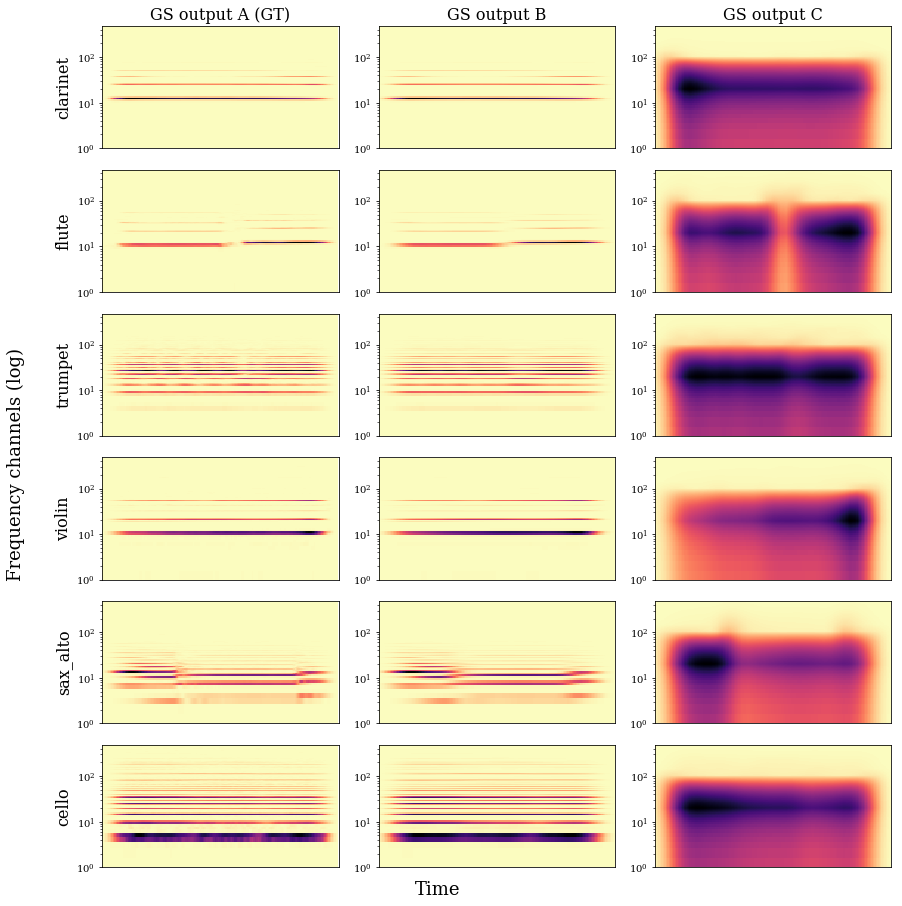

In [33]:
# Plot one sample from each class
GS_b0 = GS_vis_seq.__getitem__(0) # Get one batch
GT_b0 = GT_vis_seq.__getitem__(0) # Get one batch
order = [5, 1, 4, 3, 2, 0] # Ordering of classes at the beginning of 0th batch

cmap='magma_r'

fig, axes = plt.subplots(6, 3, sharey=False, sharex=False, figsize=(13,13))
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

fig.text(0.04, 0.5, 'Frequency channels (log)', va='center', rotation='vertical', fontsize=18)

for i, orderidx in enumerate(order): 
    GS_sample = GS_b0[0][orderidx]
    GS_label = GS_b0[1][orderidx]

    axes[i][0].imshow(GS_sample[0], aspect='auto', origin='lower', cmap=cmap)
    axes[i][0].set_yscale('log')
    axes[i][0].set_ybound(1, 480)
    axes[i][0].set_xticks([])
    axes[i][0].set_ylabel('{}'.format(onehot_to_label[tuple(GS_label)]), fontsize=16)
    if i == 0:
        axes[i][0].set_title('GS output A (GT)', fontsize=16, fontfamily='serif')

    axes[i][1].imshow(GS_sample[1], aspect='auto', origin='lower', cmap=cmap)
    axes[i][1].set_yscale('log')
    axes[i][1].set_ybound(1, 480)
    axes[i][1].set_xticks([])
    if i == 0:
        axes[i][1].set_title('GS output B', fontsize=16, fontfamily='serif')

    axes[i][2].imshow(GS_sample[2], aspect='auto', origin='lower', cmap=cmap)
    axes[i][2].set_yscale('log')
    axes[i][2].set_ybound(1, 480)
    axes[i][2].set_xticks([])
    if i == 0:
        axes[i][2].set_title('GS output C', fontsize=16, fontfamily='serif')

fig.text(0.5, 0.04, 'Time', ha='center', rotation='horizontal', fontsize=18)
fig.tight_layout(rect=[0.08, 0.05, 1, 1])
plt.savefig('experiments/sample_vis.pdf', dpi=100, bbox_inches='tight')
plt.show()

# 9. Definition of the Fully Convolutional Neural Network model

In [11]:
def dcnn_model(opt='adam', bn_in=False, nkernel=64, lr=0.001, drop=0.0, kr=0.005, decay=0.0, loss='categorical_crossentropy'):
    nkernel = int(nkernel)
    
    rep_shape = shapes[rep]
    inputs = Input(batch_shape=(None, *rep_shape))
    a = Permute((2,3,1))(inputs)

    reg_dens = regularizers.l2(kr)

    a = BatchNormalization(axis=-1)(a)
    a = Conv2D(nkernel, kernel_size=(3,3), strides=(1,1),padding='same', data_format='channels_last', activation='relu')(a)
    a = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same', data_format='channels_last')(a)

    a = Conv2D(nkernel, kernel_size=(3,3), strides=(1,1),padding='same', data_format='channels_last', activation='relu')(a)
    a = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same', data_format='channels_last')(a)

    a = Conv2D(nkernel, kernel_size=(3,3), strides=(1,1),padding='same', data_format='channels_last', activation='relu')(a)
    a = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same', data_format='channels_last')(a)

    a = Conv2D(16, kernel_size=(3,3), strides=(1,1),padding='same', data_format='channels_last', activation='relu')(a)
    a = AveragePooling2D(pool_size=(4, 4), strides=None, padding='same', data_format='channels_last')(a)

    a = Flatten()(a)
    outputs = Dense(6, kernel_regularizer=reg_dens, activation='softmax')(a)
    
    m =  Model(inputs, outputs)

    from keras.optimizers import SGD

    # Pick the optimizer
    if opt == 'sgd':
        optimizer = SGD(lr=lr, momentum=0.0, decay=decay, nesterov=False)
    elif opt == 'adam':
        optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999,
                         epsilon=None, decay=decay, amsgrad=False)

    m.compile(optimizer, loss=loss, metrics=['accuracy'])
    print(m.summary())
    return m

# 10. Training the model

You can either start training without pregenerating the batches. Or you can pregenerate them.

<font color='red'>Be aware that the very first epoch will take significantly longer than all others, if you do not pregenerate the batches, since all the batches are being created. If the batches were generated before, let's say on previous run or the previous experiment with the same tf_params, than it is not going to crete the batches again.</font>

In [ ]:
hyperparameter_space = np.array([
    # 0
    [64.000],    # N kernels
    [0.001],    # Lr
    [0.000],    # Decay
    [0.000],    # Dropout
    [0.005],    # Kernel reg
]).T 

opt = 'adam'
space_element = hyperparameter_space[0]

# Total number of training batches is 1100
for rep in ['GT', 'GS']:
    train_params.update({'rep': rep})
    for ntrain_batches in [5, 11, 55, 110, 550]:
        
        # In order to spend equal amount of computational effort on each of the experiments
        # here we specify for how many epochs it should run. The number of epochs is based
        # on number of weight updates done throughout the whole training. One weight
        # update is made after each batch. Here we limit the exps to 11k weight updates.
        # i.e. with ntrain_batches = 550, n_epochs = 20 we obtain 20 * 550 = 11000 weight updates.
        
        def get_n_epochs(ntrain_batches, weight_updates):
            return int(weight_updates / ntrain_batches)
        
        train_params.update({'epochs': get_n_epochs(ntrain_batches, train_params['weight_updates'])})
        
        variants = [
                    ({'alpha': 0}, 'seed_{}_{}_{}_{}_catcross'.format(train_params['seed'], rep, ntrain_batches, opt)), 
        ]
        for variant_params in variants:
            limited_train_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                                         rep=train_params['rep'], batch_size=train_params['batch_size'],
                                         cache_folder=paths['path_cache'], tf_params=tfparams,
                                         scaling_func=get_scaling_f(train_params['scaling']), 
                                         keep_in_ram=train_params['keep_in_ram'], 
                                         separate_inputs=train_params['separate_inputs'], 
                                         ntrain_batches=ntrain_batches)
            
            # Creating validation sequence
            valid_seq = TimeFreqSequence(df=csv_split, set_name='valid', labels_df=labels, class_col='instrument',
                                         rep=train_params['rep'], batch_size=train_params['batch_size'],
                                         cache_folder=paths['path_cache'], tf_params=tfparams,
                                         scaling_func=get_scaling_f(train_params['scaling']), 
                                         keep_in_ram=train_params['keep_in_ram'], 
                                         separate_inputs=train_params['separate_inputs'])

            # Creating test sequence
            test_seq = TimeFreqSequence(df=csv_split, set_name='test', labels_df=labels, class_col='instrument',
                                        rep=train_params['rep'], batch_size=train_params['batch_size'], 
                                        cache_folder=paths['path_cache'], tf_params=tfparams,
                                        scaling_func=get_scaling_f(train_params['scaling']), 
                                        keep_in_ram=train_params['keep_in_ram'], 
                                        separate_inputs=train_params['separate_inputs'])
            
            run_experiment(dcnn_model, opt='adam', i=0, trainseq=limited_train_seq, 
                           validseq=valid_seq, testseq=test_seq,
                           train_params=train_params, space_element=space_element,
                           variant_params=variant_params[0], 
                           variant_name=variant_params[1], 
                           paths=paths)

# 11. Evaluate the experiment outputs

Here we create 3 result files:

* results-stats.csv
* results-permodel.csv
* results-all.csv

And multiple plots each comparing a pair of TF representations.

In [13]:
# Get the paths to log file of each experiment
logs = []
for root, dirs, files in os.walk('experiments'):
    for file in files:
        if file.endswith('training.csv'):
            logs.append(os.path.join(root, file))
                      
logs_TF = [[f for f in logs if '{}_'.format(tf) in f] for tf in tfparams.keys()]

# Put the experiments results into Pandas DataFrame
dfs = []
for tf in logs_TF:
    for log in tf:
        df = pd.read_csv(log)
        ids = log.split('/')[-2].replace('-', '_').split('_')

        df['rep'] = ids[4]
        df['variant'] = ids[-1]
        df['train_size'] = ids[5]
        df['epochs'] = df['epoch'].max() + 1
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.to_csv('experiments/results_all.csv', index=False, 
          columns=['rep', 'train_size', 'epochs', 'epoch', 
                   'acc', 'loss', 'train_acc', 'train_loss', 
                   'val_acc', 'val_loss', 'test_acc', 
                   'test_loss', 'variant'])
df

epoch       acc      loss  test_acc  test_loss  train_acc  train_loss  \
0         0  0.801023  0.606961  0.902792   0.360874   0.900355    0.356016   
1         1  0.920696  0.286883  0.942375   0.215900   0.949418    0.198386   
2         2  0.935014  0.238029  0.951917   0.196763   0.958395    0.171801   
3         3  0.955881  0.173310  0.966292   0.142915   0.968054    0.132034   
4         4  0.965156  0.141381  0.959583   0.168837   0.966634    0.147794   
5         5  0.971619  0.119084  0.975917   0.102901   0.981719    0.086548   
6         6  0.973139  0.113863  0.981875   0.088995   0.987855    0.069998   
7         7  0.982116  0.082592  0.981708   0.095162   0.987244    0.068554   
8         8  0.980923  0.087079  0.986917   0.067487   0.990938    0.054439   
9         9  0.985597  0.068173  0.980750   0.081309   0.987088    0.062449   
10       10  0.986023  0.066626  0.989583   0.058749   0.993352    0.045704   
11       11  0.980895  0.080624  0.977958   0.095223   0.982415    0.082413   
12       12  0.989886  0.053454  0.988083   0.057629   0.992472    0.043736   
13       13  0.990753  0.047676  0.990375   0.047590   0.993778    0.037639   
14       14  0.979702  0.080840  0.986208   0.062780   0.989716    0.054046   
15       15  0.992358  0.043237  0.992000   0.041560   0.996179    0.031077   
16       16  0.990909  0.045665  0.992500   0.042580   0.995114    0.032902   
17       17  0.991520  0.042836  0.987708   0.057308   0.992429    0.039296   
18       18  0.986932  0.057926  0.986625   0.059227   0.992031    0.040245   
19       19  0.990852  0.044078  0.993167   0.038162   0.996349    0.029591   
20        0  0.186080  1.826321  0.193875   1.776293   0.189631    1.773295   
21        1  0.319602  1.675733  0.437458   1.545472   0.446733    1.522337   
22        2  0.464489  1.451119  0.513750   1.348800   0.523438    1.330468   
23        3  0.582386  1.228640  0.620250   1.171432   0.630682    1.128937   
24        4  0.651278  1.058934  0.645042   1.014429   0.660511    0.953008   
25        5  0.678267  0.927232  0.702667   0.920295   0.710938    0.862882   
26        6  0.709517  0.844929  0.718500   0.865031   0.745028    0.777599   
27        7  0.727983  0.813117  0.739000   0.863640   0.761364    0.755058   
28        8  0.750000  0.751986  0.740792   0.812035   0.757812    0.706306   
29        9  0.771307  0.703045  0.762333   0.759728   0.786222    0.648438   
...     ...       ...       ...       ...        ...        ...         ...   
1106     70  0.990057  0.053680  0.980958   0.079659   0.990838    0.049896   
1107     71  0.988423  0.055531  0.974375   0.100876   0.986080    0.072086   
1108     72  0.988423  0.061427  0.978917   0.099125   0.989062    0.052614   
1109     73  0.991051  0.050400  0.982833   0.080655   0.993324    0.046333   
1110     74  0.988565  0.054248  0.962875   0.147896   0.978338    0.085673   
1111     75  0.991974  0.046430  0.982208   0.080902   0.992401    0.045263   
1112     76  0.992827  0.046390  0.981792   0.076594   0.992969    0.043130   
1113     77  0.994460  0.038672  0.983708   0.077223   0.994673    0.039434   
1114     78  0.990767  0.046336  0.984875   0.072475   0.993111    0.039326   
1115     79  0.984375  0.067314  0.975083   0.111981   0.988352    0.058265   
1116     80  0.988352  0.057531  0.980500   0.092368   0.988281    0.059545   
1117     81  0.991619  0.046174  0.981125   0.084653   0.992330    0.042323   
1118     82  0.994105  0.039613  0.970667   0.119161   0.983452    0.062927   
1119     83  0.965270  0.127802  0.981125   0.086935   0.992543    0.049346   
1120     84  0.992827  0.044634  0.984125   0.076174   0.994460    0.040467   
1121     85  0.996236  0.036118  0.984875   0.072648   0.996094    0.033916   
1122     86  0.987926  0.053043  0.979958   0.092185   0.991761    0.049527   
1123     87  0.988210  0.056320  0.984542   0.079225   0.994602    0.039219   
1124     88  0.995455  0.036744  0.988333   0.057405   0

In [15]:
# Get only the best epoch per model
be = best_epochs(paths['path_experiments'], os.path.join(paths['path_experiments'], 'results-permodel.csv'))
be

batch_size scaling rep  separate_inputs  weight_updates  verbose  \
0000         128    None  GS            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  GT            False           11000        1   
0000         128    None  GT            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  GT            False           11000        1   
0000         128    None  GT            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  GT            False           11000        1   

      shuffle  seed  initial_epoch  keep_in_ram  \
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   

                       ...                     drop     kr  alpha  model_no  \
0000                   ...                      0.0  0.005      0         0   
0000                   ...                      0.0  0.005      0         0   
0000                   ...                      0.0  0.005      0         0   
0000                   ...                      0.0  0.005      0         0   
0000                   ...                      0.0  0.005      0         0   
0000                   ...                      0.0  0.005      0         0   
0000                   ...                      0.0  0.005      0         0   
0000                   ...                      0.0  0.005      0         0   
0000                   ...                      0.0  0.005      0         0   
0000                   ...                      0.0  0.005      0         0   

                             variant  best_epoch  train_acc   val_acc  \
0000  seed_5610_GS_550_adam_catcross          19   0.996349  0.991208   
0000  seed_5610_GS_110_adam_catcross          97   0.998509  0.990042   
0000  seed_5610_GT_550_adam_catcross          15   0.993437  0.989500   
0000  seed_5610_GT_110_adam_catcross          88   0.998082  0.988083   
0000   seed_5610_GS_55_adam_catcross         176   0.999574  0.984625   
0000   seed_5610_GT_55_adam_catcross         154   0.999858  0.984000   
0000   seed_5610_GT_11_adam_catcross         156   0.994318  0.919417   
0000   seed_5610_GS_11_adam_catcross          90   0.977273  0.916625   
0000    seed_5610_GS_5_adam_catcross          96   0.978125  0.868542   
0000    seed_5610_GT_5_adam_catcross          96   0.976562  0.859542   

      test_acc                                      exp  
0000  0.993167  exp-0000-seed_5610_GS_550_adam_catcross  
0000  0.990042  exp-0000-seed_5610_GS_110_adam_catcross  
0000  0.990833  exp-0000-seed_5610_GT_550_adam_catcross  
0000  0.988333  exp-0000-seed_5610_GT_110_adam_catcross  
0000  0.985292   exp-0000-seed_5610_GS_55_adam_catcross  
0000  0.982875   exp-0000-seed_5610_GT_55_adam_catcross  
0000  0.923833   exp-0000-seed_5610_GT_11_adam_catcross  
0000  0.917667   exp-0000-seed_5610_GS_11_adam_catcross  
0000  0.874833    exp-0000-seed_5610_GS_5_adam_catcross  
0000  0.865292    exp-0000-seed_5610_GT_5_adam_catcross  

[10 rows x 27 columns]

In [15]:
# Compute mean and std of accuracies accross all models 
gbe = be[['train_acc', 'val_acc', 'test_acc', 'best_epoch']].groupby([be['rep']])
gbem = gbe.mean()
gbes = gbe.std()[['train_acc', 'val_acc', 'test_acc']]
stats = pd.merge(left=gbem, right=gbes, how='left', left_index=True, right_index=True, suffixes=('_mean', '_std'))
stats.to_csv(os.path.join(paths['path_experiments'], 'results-stats.csv'))
stats

train_acc_mean  val_acc_mean  test_acc_mean  best_epoch  train_acc_std  \
rep                                                                           
GS         0.989966      0.950208       0.952200        95.6       0.011262   
GT         0.992452      0.948108       0.950233       101.8       0.009267   

     val_acc_std  test_acc_std  
rep                             
GS      0.055339      0.053347  
GT      0.057591      0.054949

# Simple plot of validation accuracy over weight update

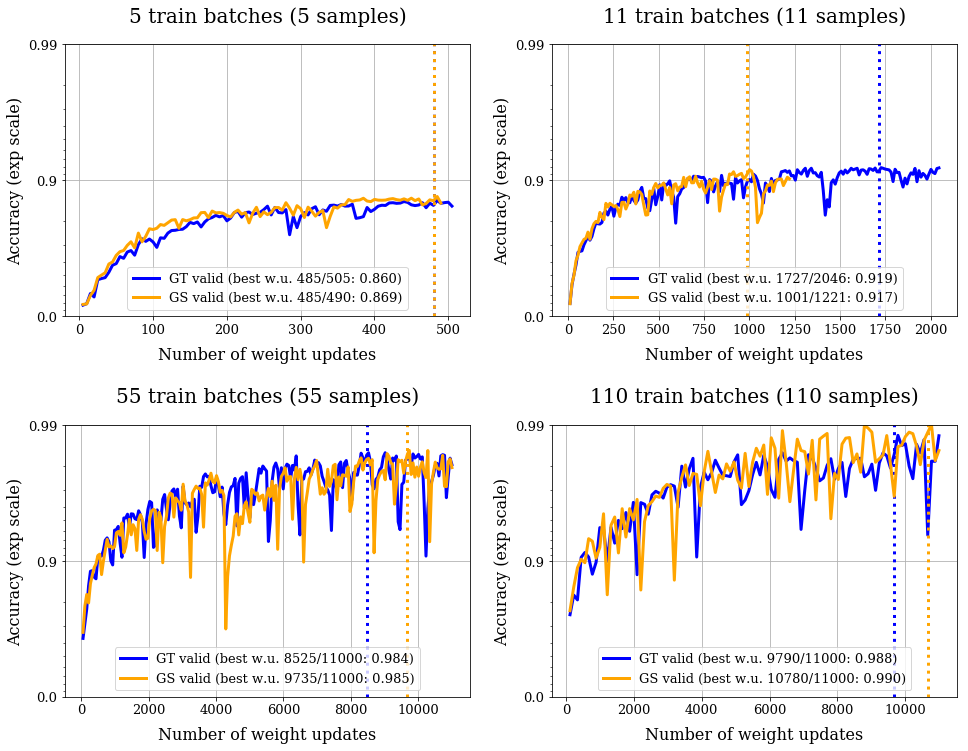

In [71]:
def plot_comparison(grp, tuple_indexer1, tuple_indexer2, weight_updates, 
                    color1='blue', color2='orange', lw1=3, lw2=1.5, 
                    legend_loc='upper center'):
    
    
    epochs = np.max([len(grp.groups[tuple_indexer1]), 
                     len(grp.groups[tuple_indexer2])])
        
    plt.rcParams.update({'font.size': 13})
    plt.title('{} train batches ({} samples)'.format(int(tuple_indexer1[1]), 
                                                     tuple_indexer1[1]), fontsize=20, y=1.06)
    plt.ylabel('Accuracy (exp scale)', fontsize=16)
    plt.xlabel('Number of weight updates', fontsize=16, labelpad=10)
    plt.grid(True)

    s1 = int(tuple_indexer1[1])
    y1 = np.array(grp.get_group(tuple_indexer1)['val_acc'].values)
    x1 = (np.arange(len(y1)) + 1) * s1
    n1 = name1 = '{} valid (best w.u. {}/{}: {:.3f})'.format(
        tuple_indexer1[0], (np.argmax(y1) + 1) * s1, len(y1) * s1, np.max(y1))
    
    s2 = int(tuple_indexer2[1])
    y2 = np.array(grp.get_group(tuple_indexer2)['val_acc'].values)
    x2 = (np.arange(len(y2)) + 1) * s2
    n2 = name1 = '{} valid (best w.u. {}/{}: {:.3f})'.format(
        tuple_indexer2[0], (np.argmax(y2) + 1) * s2, len(y2) * s2, np.max(y2))
    
    
    plt.plot(x1, 1 - y1, label=n1, color=color1, linewidth=lw1, linestyle='solid')  # Test
    plt.axvline(np.argmax(y1) * s1, linestyle='dotted', color=color1, linewidth=lw1)
    plt.plot(x2, 1 - y2, label=n2, color=color2, linewidth=lw1, linestyle='solid')  # Test
    plt.axvline(np.argmax(y2) * s2, linestyle='dotted', color=color2, linewidth=lw1)
    
    ##########################
    # Custom exponential scale
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.ylim(1, 0.01)
    plt.yticks([0.01, 0.1, 1], ['0.99', '0.9', '0.0'])
    ##########################
    
    plt.legend(loc=legend_loc)
    return plt
    
    
grp = df.groupby(['rep', 'train_size'])
plt.figure(figsize=(16, 12))

for i, s in enumerate([5, 11, 55, 110]):

    plt.subplot(2,2,i + 1)
    plot_comparison(grp, ('GT', s), ('GS', s), 
                    weight_updates=train_params['weight_updates'], 
                    legend_loc='lower center')


plt.subplots_adjust(hspace = .40)
plt.savefig('experiments/GT_vs_GS.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

# Plotting after which weight update the model surpassed certain performance threshold - measured by accuracy metric on test set

In the training log, we keep the information about accuracy after each epoch. Each epoch consists of multiple batches. One weight update is done afer each batch. Validation accuracy is measured at the end of each epoch. All models were set to train for 11k weight updates with early stopping callback, i.e. the model would automatically stop training after 50 epochs since the last improvement in validation loss as measured by categorical crossentropy loss.

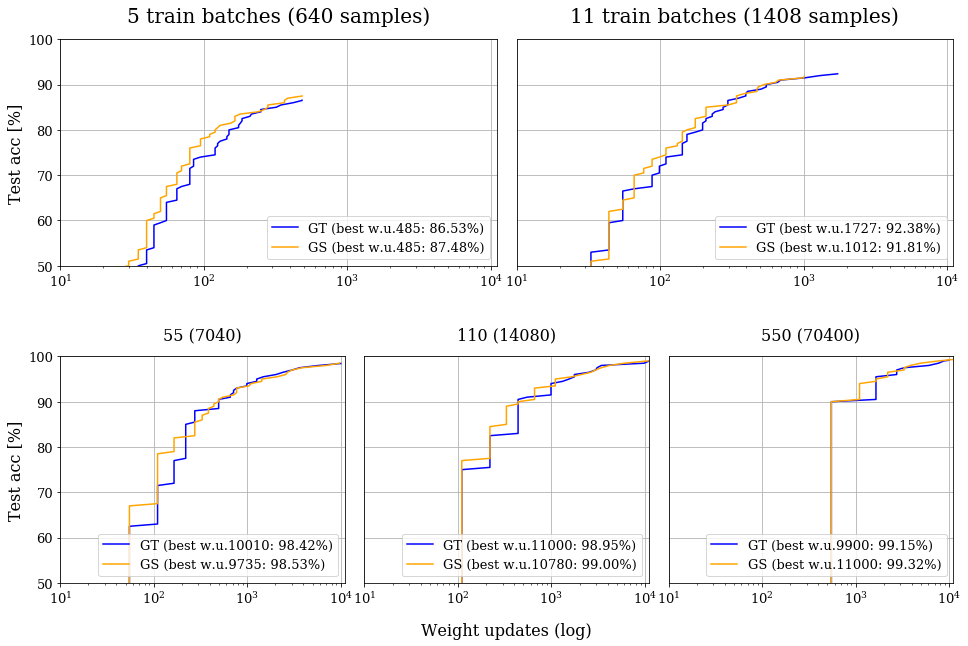

In [62]:
def get_steps(val_acc, steps, weight_updates_per_epoch=1):
    """
    Maps accuracy steps (e.g. [0.5, 0.7, 0.9]) to weight update after which
    the models' accuracy surpassed the aforementioned step.
    """
    dic = {}
    for s in steps:
        try:
            dic[s] = (np.where(val_acc >= s)[0][0] + 1) * weight_updates_per_epoch
        except:
            dic[s] = np.nan
    return dic

grp = df.groupby(['rep', 'train_size'])

# Organize the plot into a grid
grid = plt.GridSpec(2, 6, wspace=0.15, hspace=0.4)
locs = {0: (0, slice(0,3)), 
            1: (0, slice(3,6)), 
            2: (1, slice(0,2)), 
            3: (1, slice(2,4)), 
            4: (1, slice(4,6))}
plt.figure(figsize=(16, 10))
sizes = [5, 11, 55, 110, 550]

for i, s in enumerate(sizes):
    # plt.subplot(int(len(sizes))/2,2,i+1)
    plt.subplot(grid[locs[i][0], locs[i][1]])

    for rep, color in zip(['GT', 'GS'], ['blue', 'orange']):
        scores = grp.get_group((rep, s))['test_acc'] # from 
        steps = np.arange(0.2, 1.0, 0.005)
        best_wupdate = (np.argmax(scores.values) + 1) * s
        best_performance = float(np.max(scores.values))
        steps = np.sort(list(steps) + [best_performance])
        d = get_steps(scores, 
                      steps=steps, 
                      weight_updates_per_epoch=s)
        
        x = d.values()
        y = d.keys()
        plt.plot(x, y, color=color, label='{} (best w.u.{}: {:.2f}%)'.format(
            rep,
            best_wupdate,
            best_performance * 100))
    
    plt.rcParams.update({'font.size': 13})
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    yticks = np.arange(0.2, 1.1, 0.1)
    plt.yticks(yticks, (yticks * 100).astype(np.int))
    plt.grid(True)
    plt.xlim(10, 11000)
    plt.xticks([10, 100, 1000, 10000])
    plt.xscale('log')
    if i in [0, 1]:
        plt.title('{} train batches ({} samples)'.format(s, s*128), fontsize=20, y=1.05)
        plt.ylim(0.5, 1.0)
    else:
        plt.title('{} ({})'.format(s, s*128), fontsize=16, y=1.05)
        plt.ylim(0.5, 1.0)
    if i in [0, 2]:
        plt.ylabel('Test acc [%]', fontsize=16)  #(iterated by  0.5%)
    else:
        plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    if i == 3:
        plt.xlabel('Weight updates (log)', fontsize=16, labelpad=16)
    plt.legend(loc='lower right')

plt.savefig('experiments/GT_vs_GS_reach.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.close()